# Setup

In [1]:
from array import array
from pathlib import Path

import confuse
import pandas

from classifier import DialogueActClassifierFactory
from matplotlib import pyplot
from pandas import DataFrame
from sklearn import metrics

cfg = confuse.LazyConfig('ccc4prc', __name__)
# Add overrides on top of config.yaml for the workspace.
cfg.set_file('./config.workspace.yaml')

dac_factory = DialogueActClassifierFactory()
dac_labels = dac_factory.get_classifier(
    Path(cfg['dialogue_act_classification']['classifier_file'].as_filename()),
    cfg['dialogue_act_classification']['test_set_percentage'].as_number()).labels()

dataset_dir = Path(cfg['machine_learning']['labeled_seed_excel_file'].as_filename()).parent
training_dataset_file = dataset_dir / ('training_dataset.csv')
test_dataset_file = dataset_dir / ('test_dataset.csv')

training_dataset = pandas.read_csv(training_dataset_file)
test_dataset = pandas.read_csv(test_dataset_file)

FEATURES = ['body', 'dialogue_act_classification_ml', 'comment_is_by_author']
LABEL = 'program_comprehension_challenge'
report_dict_list = []

# Dialogue Act Classifier Performance

In [2]:
from collections import defaultdict

precisions, recalls = dac_factory.get_precision_and_recall()
precisions_recalls = [precisions, recalls]

dac_report = {}
dac_report[''] = [None, None, dac_factory.get_accuracy()]
for label in precisions.keys():
  dac_report[label] = [i[label] for i in precisions_recalls]

df = DataFrame.from_dict(dac_report, orient='index', columns=['Precision', 'Recall', 'Accuracy'])

df

,Precision,Recall,Accuracy
,NaN,NaN,0.666667
Statement,0.666667,0.593023,NaN
Emotion,0.989247,0.666667,NaN
System,0.951456,0.911628,NaN
Greet,1.000000,0.804878,NaN
Accept,0.615385,0.216216,NaN
Reject,0.157895,0.166667,NaN
whQuestion,0.746269,0.769231,NaN
Continuer,0.000000,0.000000,NaN
ynQuestion,0.671429,0.734375,NaN


# Dialogue Act Classifier Confusion Matrix

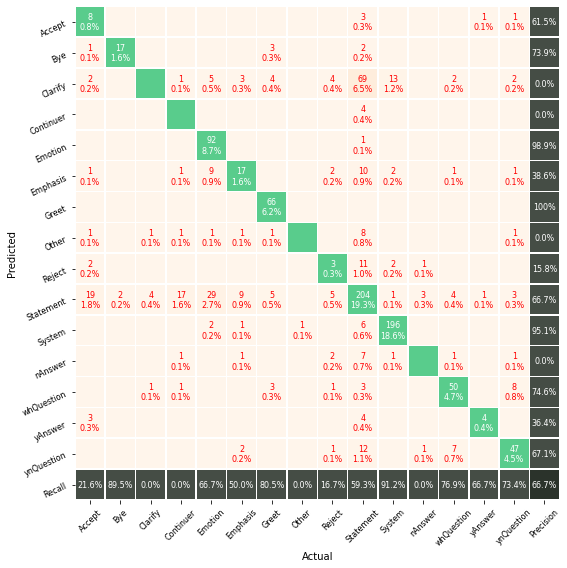

In [3]:
import seaborn
from matplotlib import pyplot

cm = dac_factory.print_confusion_matrix()

# Evenly distribute the training data labelled as "No" and "Yes".

In [4]:
X_train = training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train = training_dataset[LABEL]
y_true = test_dataset[LABEL]

min_label_count = y_train.value_counts().min()
labelled_yes = training_dataset.loc[training_dataset[LABEL] == 'Yes'].head(min_label_count)
labelled_no = training_dataset.loc[training_dataset[LABEL] == 'No'].head(min_label_count)
evenly_distrubted_training_dataset = pandas.concat([labelled_yes, labelled_no])

# Shuffle the order, in order to properly train the model.
evenly_distrubted_training_dataset = evenly_distrubted_training_dataset.sample(frac=1)

X_train_evenly_dist = evenly_distrubted_training_dataset[FEATURES]
y_train_evenly_dist = evenly_distrubted_training_dataset[LABEL]

# Show the datasets value counts
dataset_dict = {}
dataset_dict['Training Dataset'] = len(training_dataset.loc[training_dataset[LABEL] == "Yes"]), len(training_dataset.loc[training_dataset[LABEL] == "No"]), len(training_dataset.loc[training_dataset[LABEL] == "Yes"])/len(training_dataset)
dataset_dict['Test Dataset'] = len(test_dataset.loc[test_dataset[LABEL] == "Yes"]), len(test_dataset.loc[test_dataset[LABEL] == "No"]), len(test_dataset.loc[test_dataset[LABEL] == "Yes"])/len(test_dataset)
df = DataFrame.from_dict(dataset_dict, orient='index', columns=['Label (Yes)', 'Label (No)', 'Ratio (Yes)'])

df

,Label (Yes),Label (No),Ratio (Yes)
Training Dataset,92,506,0.153846
Test Dataset,39,111,0.260000


# Set up

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

is_author_categories = [
    False,  # 0 should come before 1 for numerical columns.
    True
]

# CountVectorizer - SVC

In [6]:
from sklearn.svm import SVC

column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_count_vectorizer',
            CountVectorizer(stop_words='english'),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_count_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

clf_svc = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', probability=True))],
    verbose=False)

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CountVectorizer - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CountVectorizer - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - SVC

In [7]:
column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_tfidf_vectorizer',
            TfidfVectorizer(stop_words='english', ngram_range=(1, 2)),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_tfidf_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Stemming - SVC

In [8]:
from nltk.stem.snowball import SnowballStemmer

class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english', ignore_stopwords=True)
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

column_transformer = ColumnTransformer(
    transformers=[
        ('body_count_vectorizer', StemmedCountVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_count_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Stemming - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Stemming - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - SVC

In [9]:
from nlp import LemmaTokenizer

column_transformer = ColumnTransformer(
    transformers=[
        (
            'body_tfidf_vectorizer',
            TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', lowercase=True, ngram_range=(1, 2)),
            'body'
        ),
        (
            'dac_transformer',
            OneHotEncoder(categories=[dac_labels]),
            ['dialogue_act_classification_ml']
        ),
        (
            'is_author_transformer',
            OneHotEncoder(categories=[is_author_categories]),
            ['comment_is_by_author']
        ),
    ],
    transformer_weights={
        'body_tfidf_vectorizer': 4,
        'dac_transformer': 1,
        'is_author_transformer': 2,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=0.1, probability=True))
    ],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SVC': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_svc.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SVC (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - SGDClassifier

In [10]:
from sklearn.linear_model import SGDClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SGDClassifier(random_state=13))
    ],
    verbose=False)

clf_sgd = full_pipeline

clf_sgd.fit(X_train, y_train)
y_pred = clf_sgd.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SGDClassifier': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_sgd.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_sgd.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - SGDClassifier (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - KNeighborsClassifier

In [11]:
from sklearn.neighbors import KNeighborsClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', KNeighborsClassifier())
    ],
    verbose=False)

clf_kneighbors = full_pipeline

clf_kneighbors.fit(X_train, y_train)
y_pred = clf_kneighbors.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - KNeighborsClassifier': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_kneighbors.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_kneighbors.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - KNeighborsClassifier (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression)

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', BaggingClassifier(base_estimator=LogisticRegression(C=500000, solver='lbfgs'), max_samples=0.5, max_features=0.5))
    ],
    verbose=False)

clf_ensemble = full_pipeline

clf_ensemble.fit(X_train, y_train)
y_pred = clf_ensemble.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression)': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_ensemble.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_ensemble.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - Ensemble Classifiers (Logistic Regression) (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - MultinomialNB

In [13]:
from sklearn.naive_bayes import MultinomialNB

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', MultinomialNB(fit_prior=True))],
    verbose=False)

clf_multinominal_nb = full_pipeline

clf_multinominal_nb.fit(X_train, y_train)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - MultinomialNB': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_multinominal_nb.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - MultinomialNB (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', RandomForestClassifier(max_features='auto', bootstrap=False, class_weight={'Yes': 0.2, 'No': 0.8}, random_state=20))],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'Random Forest': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_logistic_regression.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'Random Forest (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - LogisticRegression

In [15]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', LogisticRegression(C=500000, solver='liblinear', multi_class='ovr', intercept_scaling=1, dual=True, penalty='l2'))],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - LogisticRegression': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_logistic_regression.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - LogisticRegression (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# TFIDF - Lemmatization - DecisionTree

In [16]:
from sklearn.tree import DecisionTreeClassifier

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', DecisionTreeClassifier(random_state=1, min_samples_split=0.25))],
    verbose=False)

clf_decision_tree = full_pipeline

clf_decision_tree.fit(X_train, y_train)
y_pred = clf_decision_tree.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - DecisionTree': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_decision_tree.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_decision_tree.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'TFIDF - Lemmatization - DecisionTree (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# CodeComprehensionClassifierFactory

In [17]:
from classifier import CodeComprehensionClassifierFactory

clf_optimal = CodeComprehensionClassifierFactory.get_classifier(dac_labels)

clf_optimal.fit(X_train, y_train)
y_pred = clf_optimal.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CodeComprehensionClassifierFactory': metrics.classification_report(y_true, y_pred, output_dict=True)})

clf_optimal.fit(X_train_evenly_dist, y_train_evenly_dist)
y_pred = clf_optimal.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'CodeComprehensionClassifierFactory (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Report Performance Before Grid Search (as it is time consuming)

In [18]:
x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

df

,Algorithms,no_precision,no_recall,no_f1_score,yes_precision,yes_recall,yes_f1_score,Accuracy
0,CountVectorizer - SVC,0.798450,0.927928,0.858333,0.619048,0.333333,0.433333,0.773333
1,CountVectorizer - SVC (Evenly Distributed),0.864583,0.747748,0.801932,0.481481,0.666667,0.559140,0.726667
2,TFIDF - SVC,0.768116,0.954955,0.851406,0.583333,0.179487,0.274510,0.753333
3,TFIDF - SVC (Evenly Distributed),0.876404,0.702703,0.780000,0.459016,0.717949,0.560000,0.706667
4,TFIDF - Stemming - SVC,0.767606,0.981982,0.861660,0.750000,0.153846,0.255319,0.766667
5,TFIDF - Stemming - SVC (Evenly Distributed),0.890411,0.585586,0.706522,0.402597,0.794872,0.534483,0.640000
6,TFIDF - Lemmatization - SVC,0.845528,0.936937,0.888889,0.740741,0.512821,0.606061,0.826667
7,TFIDF - Lemmatization - SVC (Evenly Distributed),0.897959,0.792793,0.842105,0.557692,0.743590,0.637363,0.780000
8,TFIDF - Lemmatization - SGDClassifier,0.902655,0.918919,0.910714,0.756757,0.717949,0.736842,0.866667
9,TFIDF - Lemmatization - SGDClassifier (Evenly ...,0.903226,0.756757,0.823529,0.526316,0.769231,0.625000,0.760000


# Tuning the model with Grid Search

In [19]:
full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SGDClassifier(random_state=13))],
    verbose=False)

yes_f1_scorer = metrics.make_scorer(metrics.f1_score, pos_label="Yes")

grid_search_cv_params = [
    # {'preprocessor__body_tfidf_vectorizer__tokenizer': [None, LemmaTokenizer()]},
    # {'preprocessor__body_tfidf_vectorizer__stop_words': [None, 'english']},
    # {'preprocessor__body_tfidf_vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 5), (2, 2), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5)]},
    {
        # 'preprocessor__transformer_weights': [
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 1, 'is_author_transformer': 2},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 1, 'dac_transformer': 100, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 4, 'dac_transformer': 100, 'is_author_transformer': 100},          
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 6, 'dac_transformer': 100, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 1, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 6},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 6, 'is_author_transformer': 100},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 100, 'is_author_transformer': 1},
        #     {'body_tfidf_vectorizer': 100, 'dac_transformer': 100, 'is_author_transformer': 6},
        # ],
        'classifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        # 'classifier__class_weight': [None, 'balanced', {'Yes': 0.175, 'No': 0.825}],
        # 'classifier__early_stopping': [True, False],
        'classifier__random_state': list(range(1, 20))
    },
    # # {'classifier__min_samples_split': [2, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]},
    # # {'classifier__min_samples_leaf': [1, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]},
    # # {'classifier__min_weight_fraction_leaf': [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]},
    # # {'classifier__max_features': [None, 1, 2, 5, 10, 'auto', 'sqrt', 'log2']},
    # {'classifier__loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']},
    # # {'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.00001, 1]},
    # # {'classifier__penalty': ['l2', 'l1', 'elasticnet']},
    # {'classifier__class_weight': [None, 'balanced', {'Yes': 0.175, 'No': 0.825}]},
    # # {'classifier__shuffle': [True, False]},
    # # {'classifier__learning_rate': ['optimal', 'constant', 'adaptive']},
    # {'classifier__early_stopping': [True, False]},
    # {'classifier__random_state': list(range(1, 100))},
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring=yes_f1_scorer, return_train_score=True, n_jobs=-1, verbose=1)

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

Fitting 5 folds for each of 171 candidates, totalling 855 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 855 out of 855 | elapsed: 17.1min finished


{'classifier__loss': 'squared_hinge', 'classifier__random_state': 16}

In [20]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__loss,param_classifier__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.853419,1.854817,1.045070,1.870861,hinge,1,"{'classifier__loss': 'hinge', 'classifier__ran...",0.685714,0.628571,0.550000,0.705882,0.689655,0.651965,0.057290,53,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,7.188862,3.600533,1.127949,2.007962,hinge,2,"{'classifier__loss': 'hinge', 'classifier__ran...",0.742857,0.666667,0.600000,0.555556,0.742857,0.661587,0.075195,36,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,4.760933,2.012408,1.162725,1.993387,hinge,3,"{'classifier__loss': 'hinge', 'classifier__ran...",0.666667,0.666667,0.558140,0.705882,0.733333,0.666138,0.059597,27,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,4.825360,2.053738,1.037234,1.762854,hinge,4,"{'classifier__loss': 'hinge', 'classifier__ran...",0.551724,0.744186,0.631579,0.687500,0.666667,0.656331,0.063800,44,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,4.225063,1.858341,1.005875,1.794266,hinge,5,"{'classifier__loss': 'hinge', 'classifier__ran...",0.705882,0.731707,0.631579,0.687500,0.685714,0.688477,0.032917,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,4.354046,1.814306,1.120258,1.916678,hinge,6,"{'classifier__loss': 'hinge', 'classifier__ran...",0.533333,0.611111,0.541667,0.551724,0.666667,0.580900,0.050836,113,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,4.545211,1.938368,1.130003,1.953721,hinge,7,"{'classifier__loss': 'hinge', 'classifier__ran...",0.647059,0.631579,0.619048,0.666667,0.620690,0.637008,0.017883,80,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,4.480059,1.913322,1.058466,1.836845,hinge,8,"{'classifier__loss': 'hinge', 'classifier__ran...",0.742857,0.666667,0.611111,0.518519,0.714286,0.650688,0.079788,55,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,4.550673,1.937875,1.127549,1.966675,hinge,9,"{'classifier__loss': 'hinge', 'classifier__ran...",0.645161,0.666667,0.634146,0.705882,0.620690,0.654509,0.029775,49,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,4.763846,1.952689,1.096336,1.932796,hinge,10,"{'classifier__loss': 'hinge', 'classifier__ran...",0.702703,0.666667,0.619048,0.571429,0.733333,0.658636,0.057894,38,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [21]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'GridSearch': metrics.classification_report(y_true, y_pred, output_dict=True)})

# GridSearch with Evenly Distributed Dataset

In [22]:
clf_grid_search_cv.fit(X_train_evenly_dist, y_train_evenly_dist)
clf_grid_search_cv.best_params_


Fitting 5 folds for each of 171 candidates, totalling 855 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 855 out of 855 | elapsed:   55.8s finished


{'classifier__loss': 'log', 'classifier__random_state': 14}

In [23]:
df = DataFrame(clf_grid_search_cv.cv_results_)

# Display the entire table.
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__loss,param_classifier__random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.302536,0.014950,0.054691,0.007590,hinge,1,"{'classifier__loss': 'hinge', 'classifier__ran...",0.909091,0.857143,0.850000,0.750000,0.702703,0.813787,0.075740,39,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.280627,0.045340,0.049194,0.005338,hinge,2,"{'classifier__loss': 'hinge', 'classifier__ran...",0.848485,0.829268,0.756757,0.787879,0.684211,0.781320,0.058115,89,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.217223,0.003182,0.041605,0.004504,hinge,3,"{'classifier__loss': 'hinge', 'classifier__ran...",0.914286,0.837209,0.764706,0.750000,0.777778,0.808796,0.060495,48,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0.204211,0.007385,0.042779,0.004697,hinge,4,"{'classifier__loss': 'hinge', 'classifier__ran...",0.971429,0.878049,0.878049,0.787879,0.769231,0.856927,0.072748,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.218737,0.018510,0.041669,0.004221,hinge,5,"{'classifier__loss': 'hinge', 'classifier__ran...",0.941176,0.857143,0.842105,0.764706,0.647059,0.810438,0.099056,46,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.257634,0.012530,0.042452,0.004362,hinge,6,"{'classifier__loss': 'hinge', 'classifier__ran...",0.971429,0.878049,0.818182,0.750000,0.628571,0.809246,0.115992,47,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,0.222730,0.017266,0.041108,0.004075,hinge,7,"{'classifier__loss': 'hinge', 'classifier__ran...",0.941176,0.809524,0.750000,0.750000,0.666667,0.783473,0.091031,82,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,0.212172,0.014259,0.040725,0.007487,hinge,8,"{'classifier__loss': 'hinge', 'classifier__ran...",0.882353,0.857143,0.810811,0.709677,0.702703,0.792537,0.074176,73,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
8,0.228767,0.010011,0.047045,0.006050,hinge,9,"{'classifier__loss': 'hinge', 'classifier__ran...",0.871795,0.850000,0.829268,0.750000,0.685714,0.797355,0.069336,65,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,0.227827,0.008941,0.043896,0.004372,hinge,10,"{'classifier__loss': 'hinge', 'classifier__ran...",0.914286,0.837209,0.864865,0.787879,0.702703,0.821388,0.072083,22,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


In [24]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
report_dict_list.append({'GridSearch (Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

# Performance Result Comparison

In [25]:
from matplotlib import pyplot

x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

df

,Algorithms,no_precision,no_recall,no_f1_score,yes_precision,yes_recall,yes_f1_score,Accuracy
0,CountVectorizer - SVC,0.798450,0.927928,0.858333,0.619048,0.333333,0.433333,0.773333
1,CountVectorizer - SVC (Evenly Distributed),0.864583,0.747748,0.801932,0.481481,0.666667,0.559140,0.726667
2,TFIDF - SVC,0.768116,0.954955,0.851406,0.583333,0.179487,0.274510,0.753333
3,TFIDF - SVC (Evenly Distributed),0.876404,0.702703,0.780000,0.459016,0.717949,0.560000,0.706667
4,TFIDF - Stemming - SVC,0.767606,0.981982,0.861660,0.750000,0.153846,0.255319,0.766667
5,TFIDF - Stemming - SVC (Evenly Distributed),0.890411,0.585586,0.706522,0.402597,0.794872,0.534483,0.640000
6,TFIDF - Lemmatization - SVC,0.845528,0.936937,0.888889,0.740741,0.512821,0.606061,0.826667
7,TFIDF - Lemmatization - SVC (Evenly Distributed),0.897959,0.792793,0.842105,0.557692,0.743590,0.637363,0.780000
8,TFIDF - Lemmatization - SGDClassifier,0.902655,0.918919,0.910714,0.756757,0.717949,0.736842,0.866667
9,TFIDF - Lemmatization - SGDClassifier (Evenly ...,0.903226,0.756757,0.823529,0.526316,0.769231,0.625000,0.760000


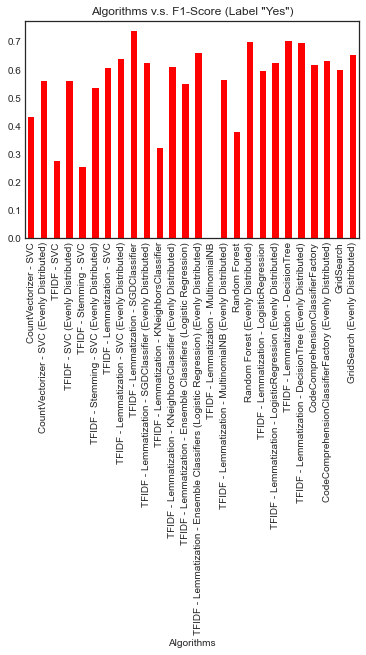

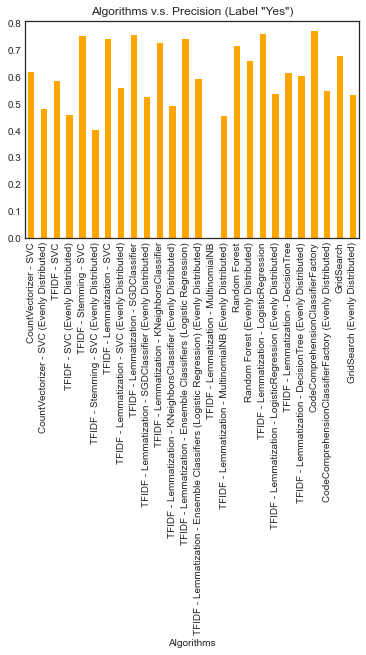

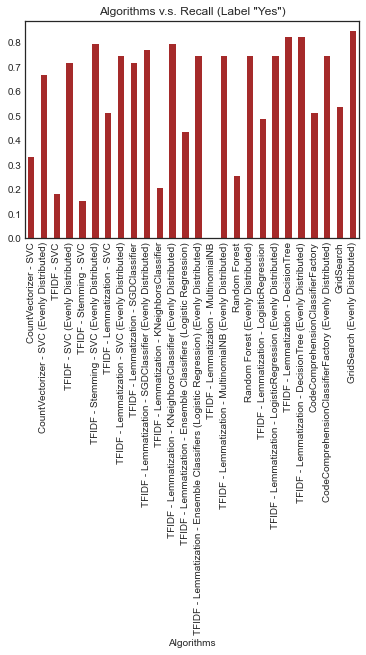

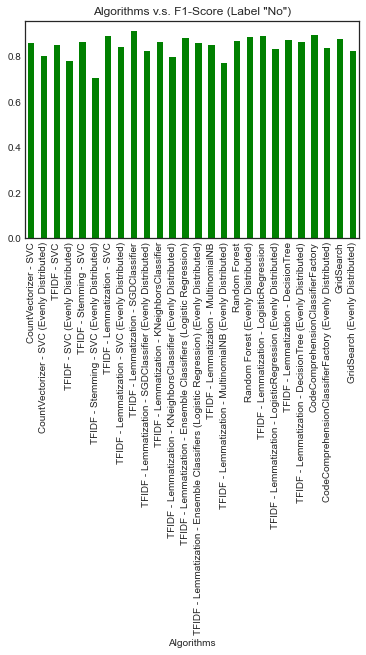

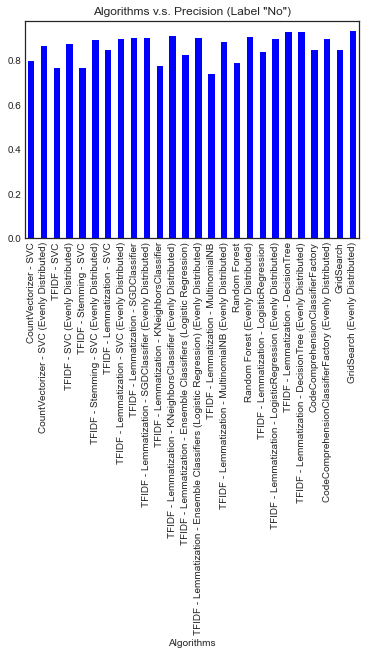

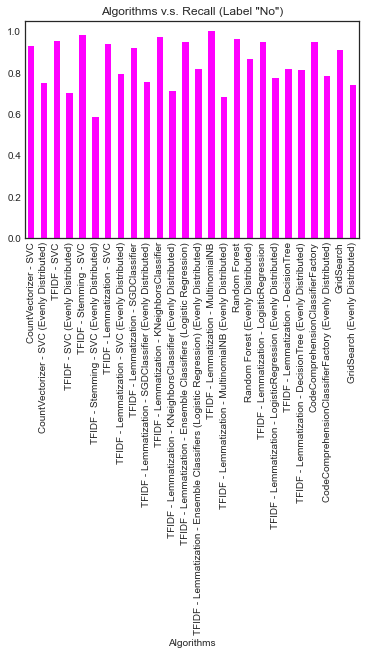

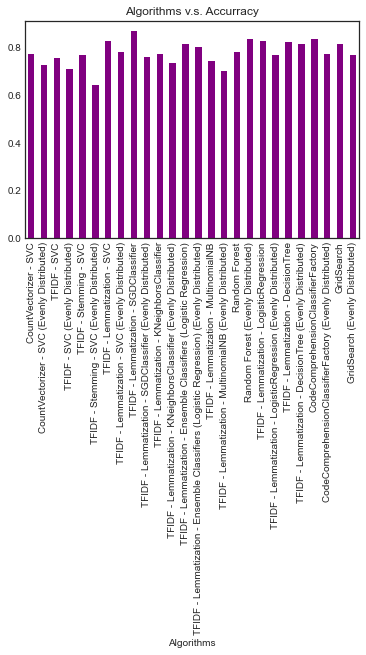

In [26]:
with pyplot.style.context('seaborn-white'):
    df.plot.bar(x='Algorithms', y='yes_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "Yes")', color='red', legend=False)
    df.plot.bar(x='Algorithms', y='yes_precision', rot=90, title='Algorithms v.s. Precision (Label "Yes")', color='orange', legend=False)
    df.plot.bar(x='Algorithms', y='yes_recall', rot=90, title='Algorithms v.s. Recall (Label "Yes")', color='brown', legend=False)
    df.plot.bar(x='Algorithms', y='no_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "No")', color='green', legend=False)
    df.plot.bar(x='Algorithms', y='no_precision', rot=90, title='Algorithms v.s. Precision (Label "No")', color='blue', legend=False)
    df.plot.bar(x='Algorithms', y='no_recall', rot=90, title='Algorithms v.s. Recall (Label "No")', color='magenta', legend=False)
    df.plot.bar(x='Algorithms', y='Accuracy', rot=90, title='Algorithms v.s. Accurracy', color='purple', legend=False)

    # axes = df.plot.bar(rot=90, title="Algorithms Performance", subplots=True)

    pyplot.show(block=False)